## Time Series Forecasting 

Time Series Forecasting is one of the many fields where Recurrent Neural Networks are proving to be extreamly effective. When you combine the basic ability of deep learning to solve high dimentional problems with the unbelievable effectiveness of RNN's to incorporate the temporal dimention, we get a pretty powerfull high dimentional seqential function approximator which can be used to solve almost all types of seqential problems. The RNN's were not so popular initially because they were notoriously difficult to train especially due to the vanishing gradient problem. Even today, with LSTM's and GRU's being extreamly effective in mitigating this vanishing gradient problem, still a typical RNN architecture will not be as deep as a normal neural network. This is because of the temporal loop inside the RNN. For example, a single RNN cell with a temporal dimention of 3 is equivallent to a 3 layer neural network consisting of a single neuron. It is now possible to imagine why it is difficult to have really deep RNN networks.

In this notebook I will be using the Californial Monthly Milk production dataset to demonstrate Time Series Forcasting using RNN. I will be using a LSTM cell here, the choise of the RNN unit is arbitrary. 

### The Data 

https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

Monthly milk production: pounds per cow. Jan 62 - Dec 75

### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Reading the data 

In [2]:
data = pd.read_csv('monthly-milk-production.csv',index_col='Month')

In [3]:
data.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
data.index = pd.to_datetime(data.index) # Resetting the index to date time 

### Plotting TS (Time Series ) Data

<Figure size 2400x1800 with 0 Axes>

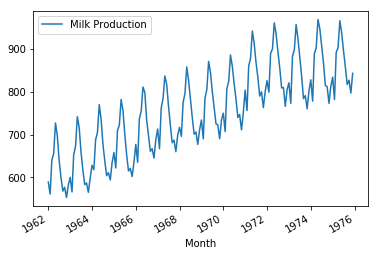

In [5]:
data.plot()

### Train Test Split

#### I am attempting to predict a year's data into the future. (12 months or 12 steps )

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [7]:
train = data.head(156)

In [8]:
test = data.tail(12)

### Scale the Data

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
sc = MinMaxScaler(feature_range=(-1,1)) # This scale is just intuitive because of the tanh activation inside RNN 

In [11]:
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

### Batch Function

In [12]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## The RNN Model

#### Importing TensorFlow

In [13]:
import tensorflow as tf

#### The Constants

In [14]:

num_inputs = 1 # Just one feature, the time series

num_time_steps = 12 # Num of steps in each batch

num_neurons = 100 # totally arbitrary 

num_outputs = 1 # Just one output, predicted time series


learning_rate = 0.01 # learning rate 

num_train_iterations = 2000 # how many iterations to go through (training steps), typically RNN's needs to be trained longer 

batch_size = 1 # Size of the batch of data

#### Placeholders 

In [15]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

#### LSTM cell 

In [16]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

Instructions for updating:
Use the retry module or similar alternatives.


In [17]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#### Loss Function and Optimizer

In [18]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

#### Initialize the global variables

In [19]:
init = tf.global_variables_initializer()

#### Saving the model 

In [20]:
saver = tf.train.Saver()

### Session

In [21]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [22]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model
    saver.save(sess, "./time_series_model")

0 	MSE: 0.17202486
100 	MSE: 0.03340601
200 	MSE: 0.026789615
300 	MSE: 0.04831688
400 	MSE: 0.016993573
500 	MSE: 0.027681177
600 	MSE: 0.032445353
700 	MSE: 0.017481575
800 	MSE: 0.017829254
900 	MSE: 0.018894693
1000 	MSE: 0.017772196
1100 	MSE: 0.02240166
1200 	MSE: 0.012871563
1300 	MSE: 0.010140599
1400 	MSE: 0.009301559
1500 	MSE: 0.011159346
1600 	MSE: 0.015042774
1700 	MSE: 0.036329035
1800 	MSE: 0.016368926
1900 	MSE: 0.01894517


## Predicting Future

#### To do this we have to feed in a seed value of training for the last 12 months from the training set to predict 12 months into the future.

In [23]:
test

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


### Generative Session

In [24]:
with tf.Session() as sess:
    
    saver.restore(sess, "./time_series_model")

    # Create a numpy array for the genreative seed from the last 12 months of the training data  
    
    train_seed = list(train_scaled[-12:])
    
   
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./time_series_model


In [26]:
train_seed

[array([0.32211538]),
 array([0.08173077]),
 array([0.61538462]),
 array([0.67788462]),
 array([1.]),
 array([0.89423077]),
 array([0.70673077]),
 array([0.50961538]),
 array([0.25961538]),
 array([0.24519231]),
 array([0.05769231]),
 array([0.25]),
 0.24887574,
 0.24495587,
 0.5061768,
 0.6908507,
 0.95473,
 0.8351105,
 0.6965271,
 0.4681637,
 0.26827097,
 0.18386032,
 0.08703298,
 0.16222647]

#### Predicting 

In [28]:
prediction = sc.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [32]:
test[' RNN Generated'] = prediction

C:\Users\Ambarish\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
test

,Milk Production,RNN Generated
Month,,
1975-01-01 01:00:00,834.0,812.766174
1975-02-01 01:00:00,782.0,811.950806
1975-03-01 01:00:00,892.0,866.284790
1975-04-01 01:00:00,903.0,904.696899
1975-05-01 01:00:00,966.0,959.583801
1975-06-01 01:00:00,937.0,934.703003
1975-07-01 01:00:00,896.0,905.877563
1975-08-01 01:00:00,858.0,858.378052
1975-09-01 01:00:00,817.0,816.800354


## Visualizing the Predictions 

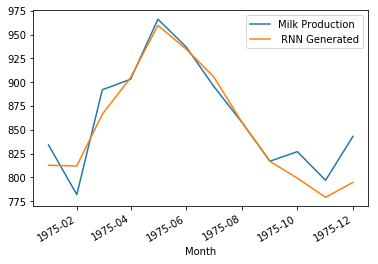

In [36]:
test.plot()

#### There a lot of hyperparameters which we can tune to make the predictions even more accurate. 